# Analyzing Global Jewish Populations Across Time

This project focuses on using Python to explore and analyze global Jewish population data, with the goal of answering the following questions:

1. How do Jewish population shares compare across countries and across world regions in each benchmark year?
2. Which countries experienced the largest percentage decline from 1931 to 1948 (a pre–post World War II benchmark in this dataset)?
3. Which countries experienced the largest percentage growth from 1948 to 2023?
   
For this dataset, we have population data from the following years:
* 1899
* 1931
* 1948
* 1992
* 2023

*Important context: Some political entities changed names and borders over time. This notebook treats each row as the dataset’s named entity for that year, so results should be interpreted cautiously when borders shift or when data is missing. For example, is not listed as a country in this dataset in 1899 (it re-emerges as a country in 1918). Missing values reflect unavailable data, not confirmed zero.*

In [178]:
YEARS = [1899, 1931, 1948, 1992, 2023]
percent_cols = [f"{y}_percent_of_population" for y in YEARS]
number_cols = [f"{y}_jewish_population" for y in YEARS]

## Data
The data used in this project is in one CSV: `jewish_populations_1899_to_2023.csv`.

Credit: Data from Echoes and Reflections was used to make this dataset.

In [179]:
# Import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

We'll need to load the dataset into pandas and inspect it.

In [180]:
jewish_populations = pd.read_csv('jewish_populations_1899_to_2023.csv')
jewish_populations.head()

,Entity,1899_jewish_population,1899_percent_of_population,1931_jewish_population,1931_percent_of_population,1948_jewish_population,1948_percent_of_population,1992_jewish_population,1992_percent_of_population,2023_jewish_population,2023_percent_of_population
0,Canada,"6,414",0.1%,"126,196",1.2%,"180,000",1.4%,"356,000",1.3%,"398,000",1.0%
1,United States,"1,043,800",1.4%,"4,229,401",3.3%,"5,000,000",3.2%,"5,620,000",2.2%,"7,500,000",2.2%
2,Mexico,0,0.0%,"16,000",0.1%,"25,000",0.1%,"40,000",<0.1%,"40,000",<0.1%
3,NORTH AMERICA,"1,050,214",1.5%,"4,371,597",4.6%,"5,205,000",4.7%,"6,016,000",3.7%,"7,938,000",3.2%
4,Guatemala,0,0.0%,0,0.0%,800,<0.1%,800,<0.1%,900,<0.1%


In [181]:
jewish_populations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Entity                      131 non-null    object
 1   1899_jewish_population      62 non-null     object
 2   1899_percent_of_population  61 non-null     object
 3   1931_jewish_population      92 non-null     object
 4   1931_percent_of_population  91 non-null     object
 5   1948_jewish_population      82 non-null     object
 6   1948_percent_of_population  82 non-null     object
 7   1992_jewish_population      107 non-null    object
 8   1992_percent_of_population  104 non-null    object
 9   2023_jewish_population      108 non-null    object
 10  2023_percent_of_population  105 non-null    object
dtypes: object(11)
memory usage: 11.4+ KB


In [182]:
missing = jewish_populations.isna().mean().sort_values(ascending=False)
missing
pd.DataFrame({
    "population_missing_%": jewish_populations[NUM_COLS].isna().mean()*100,
    "share_missing_%": jewish_populations[PCT_COLS].isna().mean()*100
}).round(1)

,population_missing_%,share_missing_%
1899_jewish_population,52.7,NaN
1899_percent_of_population,NaN,53.4
1931_jewish_population,29.8,NaN
1931_percent_of_population,NaN,30.5
1948_jewish_population,37.4,NaN
1948_percent_of_population,NaN,37.4
1992_jewish_population,18.3,NaN
1992_percent_of_population,NaN,20.6
2023_jewish_population,17.6,NaN
2023_percent_of_population,NaN,19.8


Some initial observations:

* The dataset contains 131 entities (countries and world regions).
* Several year columns have substantial missing data, especially 1899.
* Population and percent columns are stored as text (commas, %, and special values like <0.1%), so they must be converted to numeric types before analysis.

### Data Cleaning + Preparation
Before we can plot the data, we'll need to clean the column names and row values in all three DataFrames.

First, we want to clean the data.

In [221]:
# Function to clean and preprocess the DataFrame
"""
    Standardize column names and clean entity labels for reliable filtering.
    NOTE: We avoid aggressive transformations (like full title-casing acronyms)
    unless we also standardize our reference lists the same way.
    """

def normalize_columns_and_entities(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower()
    df["entity"] = df["entity"].astype(str).str.strip().str.title()
    return df

# Clean the DataFrames
jewish_populations = normalize_columns_and_entities(jewish_populations)

# View cleaned data
jewish_populations.head()  

,entity,1899_jewish_population,1899_percent_of_population,1931_jewish_population,1931_percent_of_population,1948_jewish_population,1948_percent_of_population,1992_jewish_population,1992_percent_of_population,2023_jewish_population,2023_percent_of_population
0,Canada,6414,0.001,126196,0.012,180000,0.0140,356000,0.0130,398000,0.0100
1,United States,1043800,0.014,4229401,0.033,5000000,0.0320,5620000,0.0220,7500000,0.0220
2,Mexico,0,0.000,16000,0.001,25000,0.0010,40000,0.0001,40000,0.0001
3,North America,1050214,0.015,4371597,0.046,5205000,0.0470,6016000,0.0370,7938000,0.0320
4,Guatemala,0,0.000,0,0.000,800,0.0001,800,0.0001,900,0.0001


Only the entity column is text-cleaned. Numeric columns are cleaned separately to prevent accidental changes.

In [184]:
print("Columns in jewish_populations:", jewish_populations.columns.tolist())

Columns in jewish_populations: ['entity', '1899_jewish_population', '1899_percent_of_population', '1931_jewish_population', '1931_percent_of_population', '1948_jewish_population', '1948_percent_of_population', '1992_jewish_population', '1992_percent_of_population', '2023_jewish_population', '2023_percent_of_population']


We have many cells with '<0.1%.' We want to replace that value with 0.01. We also want to remove '%' and 'N/A' from values to make them into floats.

We'll keep missing values as NaN so we don't treat "unknown" as "zero." We'll handle NaNs intentionally when computing rankings/plots. Missing values indicate unavailable estimates, not confirmed absence of population.

In [222]:
 # Convert percent strings like "1.4%" → 0.014 (decimal share)
# Treat "<0.1%" as 0.01% (0.0001 as a decimal share)

for col in percent_cols:
    jewish_populations[col] = (
        jewish_populations[col]
        .astype(str)                    # ensure string type
        .replace({'N/A': 'NaN', '<0.1%': '0.01'})
        .str.replace('%', '', regex=False)
        .astype(float)
    )
    
#Convert to decimal percentages
jewish_populations[percent_cols] = jewish_populations[percent_cols] / 100

# After cleaning, sanity-check the range
jewish_populations[PCT_COLS].describe().T[["min","max"]]

,min,max
1899_percent_of_population,0.0,0.00185
1931_percent_of_population,0.0,0.00622
1948_percent_of_population,0.0,0.00742
1992_percent_of_population,0.0,0.00973
2023_percent_of_population,0.0,0.00946


We have many cells with ',' in the numbers, which makes them objects. We want to remove those commas to make our numbers floats.

In [223]:
# Remove thousands separators and coerce to numeric; keep missing as NaN
for col in number_cols:
    # Check if the column contains string values before using .str accessor
    if jewish_populations[col].dtype == 'object':
        jewish_populations[col] = (
            jewish_populations[col]
            .str.replace(',', '', regex=False)
        )
    # If the column is already numeric, just ensure it's float type
    
jewish_populations.head()

,entity,1899_jewish_population,1899_percent_of_population,1931_jewish_population,1931_percent_of_population,1948_jewish_population,1948_percent_of_population,1992_jewish_population,1992_percent_of_population,2023_jewish_population,2023_percent_of_population
0,Canada,6414,0.00001,126196,0.00012,180000,0.000140,356000,0.000130,398000,0.000100
1,United States,1043800,0.00014,4229401,0.00033,5000000,0.000320,5620000,0.000220,7500000,0.000220
2,Mexico,0,0.00000,16000,0.00001,25000,0.000010,40000,0.000001,40000,0.000001
3,North America,1050214,0.00015,4371597,0.00046,5205000,0.000470,6016000,0.000370,7938000,0.000320
4,Guatemala,0,0.00000,0,0.00000,800,0.000001,800,0.000001,900,0.000001


We also want to make sure that we have four separate tables: two with just world regions (one with percents and one without) and two with just countries (one with percents and one without).

In [199]:
WORLD_REGIONS = [
    "North America",
    "Caribbean & Latin America",
    "Europe & Ottoman Empire",
    "Middle East & North Africa",
    "Africa",
    "Asia & Oceania"
]

# Create regions and country tables using filters
is_region = jewish_populations["entity"].isin(WORLD_REGIONS)
regions = jewish_populations[is_region].copy()
countries = jewish_populations[~is_region].copy()


# Long format - share (percents only)
regions_share = regions[["entity"] + percent_cols].melt(
    id_vars="entity", var_name="year", value_name="jewish_population_share"
)
regions_share["year"] = regions_share["year"].str.extract(r"(\d{4})").astype(int)

countries_share = countries[["entity"] + percent_cols].melt(
    id_vars="entity", var_name="year", value_name="jewish_population_share"
)
countries_share["year"] = countries_share["year"].str.extract(r"(\d{4})").astype(int)


# Long format - numbers (no percents)
regions_num = regions[
    ["entity", "1899_jewish_population", "1931_jewish_population",
     "1948_jewish_population", "1992_jewish_population", "2023_jewish_population"]
].melt(
    id_vars="entity",
    var_name="year",
    value_name="jewish_population"
)
regions_num["year"] = regions_num["year"].str.extract(r"(\d{4})").astype(int)
regions_num["jewish_population"] = pd.to_numeric(
    regions_num["jewish_population"], errors="coerce"
)

regions_num = regions_num.sort_values(["entity", "year"])


countries_num = countries[["entity"] + number_cols].melt(
    id_vars="entity", var_name="year", value_name="jewish_population"
)
countries_num["year"] = countries_num["year"].str.extract(r"(\d{4})").astype(int)


# Ensure correct types
regions_num = regions_num.copy()
regions_num['year'] = pd.to_numeric(regions_num['year'], errors='coerce')
regions_num['jewish_population'] = pd.to_numeric(regions_num['jewish_population'], errors='coerce')
regions_num = regions_num.sort_values(['entity', 'year'])

countries_num = countries_num.copy()
countries_num['year'] = pd.to_numeric(countries_num['year'], errors='coerce')
countries_num['jewish_population'] = pd.to_numeric(countries_num['jewish_population'], errors='coerce')
countries_num = countries_num.sort_values(['entity', 'year'])


#check for sanity
#regions_share
#countries_share
regions_num
#countries_num



,entity,year,jewish_population
4,Africa,1899,120000
10,Africa,1931,123949
16,Africa,1948,151000
22,Africa,1992,103600
28,Africa,2023,52400
5,Asia & Oceania,1899,46462
11,Asia & Oceania,1931,128380
17,Asia & Oceania,1948,105500
23,Asia & Oceania,1992,210000
29,Asia & Oceania,2023,155900


Now we have four new datasets: 
* `regions_share` = only shows how much of the population Jews made up in different regions over time
* `countries_share` = shows the same thing but for individual countries
* `regions_num` = shows the actual number of Jews in different regions over time
* `countries_numb` = shows the same thing but for individual countries

## Regional Comparisons

Now we can actually visualize our data! We'll start with regions, since that's the easiest. First, we'll compare the Jewish population numbers by creating a line graph for each region.

We will draw reference lines at 1931 (the pre-WWII benchmark in this dataset) and 1948 (the first postwar benchmark year included). These help visualize change around WWII and the postwar period, but 1931 is not the start of the Holocaust.

This will allow us to see the change in those 17 years.

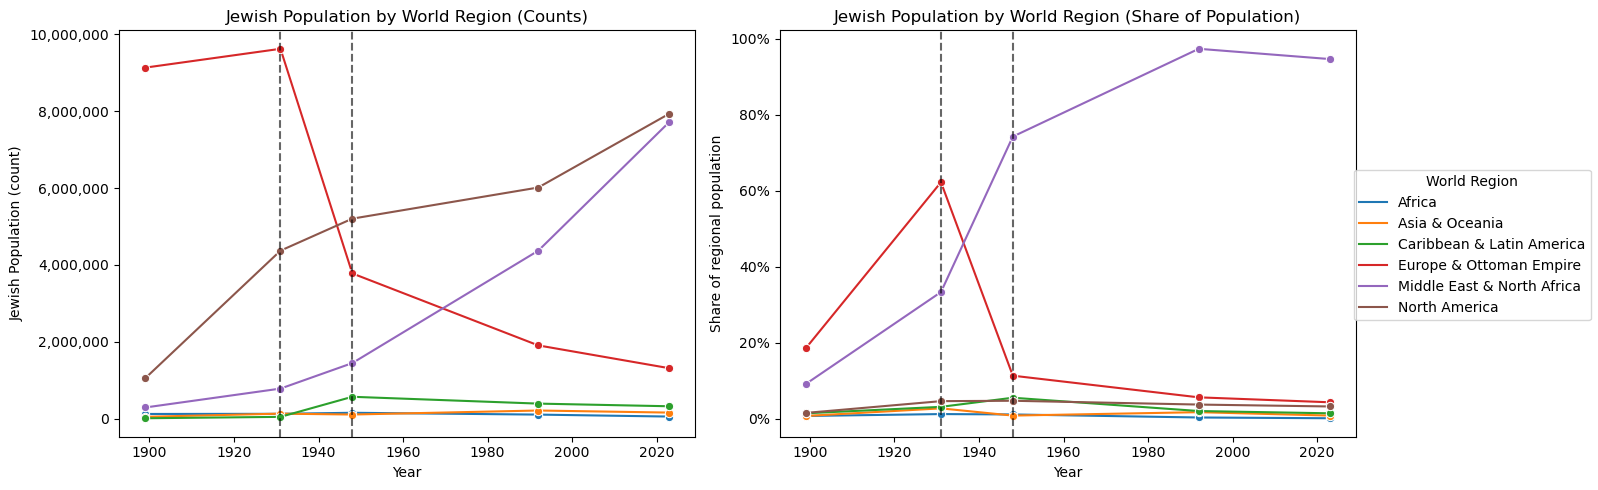

In [209]:

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

# ---- LEFT: COUNTS ----
sns.lineplot(
    data=jewish_populations_regions_numbers,
    x="year",
    y="jewish_population",
    hue="entity",
    marker="o",
    ax=ax0
)

ax0.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax0.set_title("Jewish Population by World Region (Counts)")
ax0.set_xlabel("Year")
ax0.set_ylabel("Jewish Population (count)")
ax0.axvline(1931, linestyle="--", color="black", alpha=0.6)
ax0.axvline(1948, linestyle="--", color="black", alpha=0.6)
ax0.legend().remove()

# ---- RIGHT: SHARES ----
sns.lineplot(
    data=jewish_populations_regions_share,
    x="year",
    y="jewish_population_share",
    hue="entity",
    marker="o",
    ax=ax1
)

ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.set_title("Jewish Population by World Region (Share of Population)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Share of regional population")
ax1.axvline(1931, linestyle="--", color="black", alpha=0.6)
ax1.axvline(1948, linestyle="--", color="black", alpha=0.6)

# ---- ONE SHARED LEGEND ----
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title="World Region", loc="center right")
ax1.get_legend().remove()

plt.tight_layout(rect=[0, 0, 0.86, 1])
plt.show()

In 1899 and 1931, Europe & the Ottoman Empire contains the largest Jewish population in the dataset, reflecting the long-standing concentration of Jewish communities in Central and Eastern Europe. 

Between 1931 and 1948, the Jewish population in Europe & the Ottoman Empire declined sharply, marking a major demographic rupture consistent with the effects of World War II, the Holocaust, and mass displacement.

After 1948, the largest Jewish population shifted toward North America and the Middle East & North Africa, reflecting postwar migration patterns, refugee resettlement, and the creation of Israel. By 1992 and 2023, Europe no longer represented the largest regional center of Jewish population.

This chart demonstrates why counts and shares must be analyzed together: a region can contain fewer Jews in absolute terms while still having a higher proportional concentration.

**Important limitation**: Because these are regional aggregates, this chart masks significant variation within regions (for example, differences between Western and Eastern Europe).

## Country Comparison

We can also compare the data by country. This will be a bit tricky, so we'll have to filter for the countries we want to look at. We can create a function for that.

In [211]:
    """
    Plot Jewish population counts and population shares for selected countries.
    Note: If a country name doesn't match the dataset, it will be missing from the plot.
    """

def plot_counts_vs_share_for_countries(country_list, title_prefix):
    sub_num = countries_num[countries_num["entity"].isin(country_list)].copy()
    sub_share = countries_share[countries_share["entity"].isin(country_list)].copy()

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

    ax0 = axes[0]
    sns.lineplot(data=sub_num, x="year", y="jewish_population", hue="entity", marker="o", ax=ax0)
    ax0.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
    ax0.set_title(f"{title_prefix} (Counts)")
    ax0.set_xlabel("Year")
    ax0.set_ylabel("Jewish Population (count)")
    ax0.axvline(1931, linestyle="--", color="black", alpha=0.6)
    ax0.axvline(1948, linestyle="--", color="black", alpha=0.6)
    ax0.legend().remove()

    ax1 = axes[1]
    sns.lineplot(data=sub_share, x="year", y="jewish_population_share", hue="entity", marker="o", ax=ax1)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax1.set_title(f"{title_prefix} (Share of Population)")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Share of national population")
    ax1.axvline(1931, linestyle="--", color="black", alpha=0.6)
    ax1.axvline(1948, linestyle="--", color="black", alpha=0.6)

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title="Country", loc="center right")
    ax1.get_legend().remove()

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()

Let's look at only at the United States.

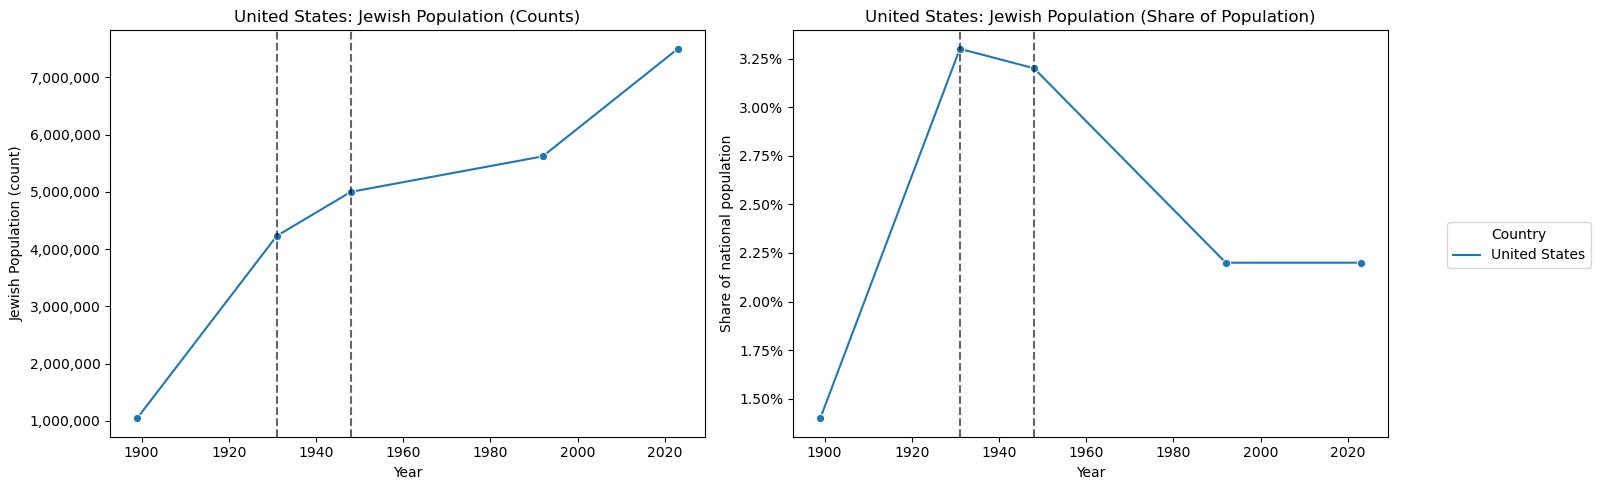

In [212]:
plot_counts_vs_share_for_countries(['United States'], "United States: Jewish Population")

We can see that around 1900, the Jewish population in the United States was about 1 million. By the 1940s, that number had grown to 5 million, and continued to grow. 

However, the shares chart shows the percentage of Jews decreasing, despite the increasing population. This is because the population share is calculated from the overall national population. If the national population continues to grow faster than the Jewish population, the Jewish share of the population will remain small and possibly decrease.

How does this compare with other countries? We’d have to choose which countries we want to look at.


Let's say we want to look at the United States, Poland, Argentina, Australia, and Israel.

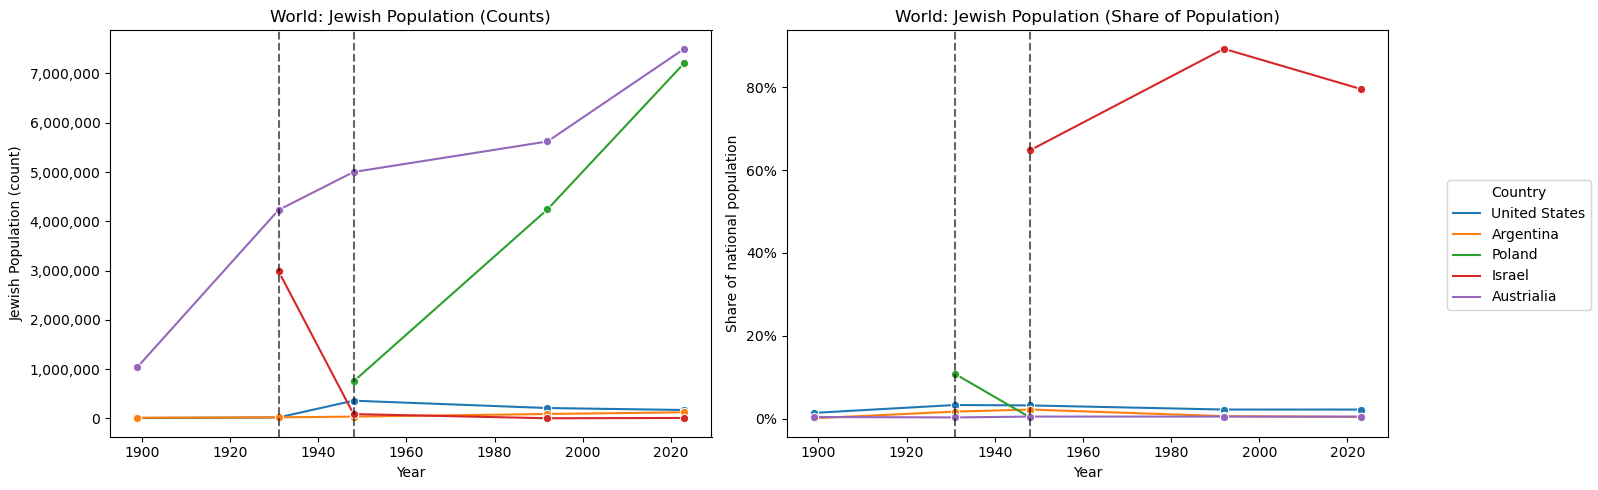

In [176]:
# List of countries to include
plot_counts_vs_share_for_countries(
    ["United States", "Argentina", "Austrialia", "Israel", "Poland"],
    "World: Jewish Population"
)

This comparison highlights how different countries experience opposite demographic trajectories over the same period. Poland’s Jewish population collapses between 1931 and 1948, while the United States and Israel experience rapid postwar growth.

Israel’s share-of-population chart is particularly striking: even when absolute numbers are still relatively small in the early years, Jews make up a large proportion of the national population after 1948.

Argentina and Australia show modest growth in absolute numbers but relatively small shares, illustrating how immigration destinations can receive significant numbers of migrants without experiencing major proportional change.

A better comparison would be across countries in the same region. Let's repeat the same process, but for Eastern Europe. Let's compare Poland, Hungary, Latvia, Lithuania, and Romania.

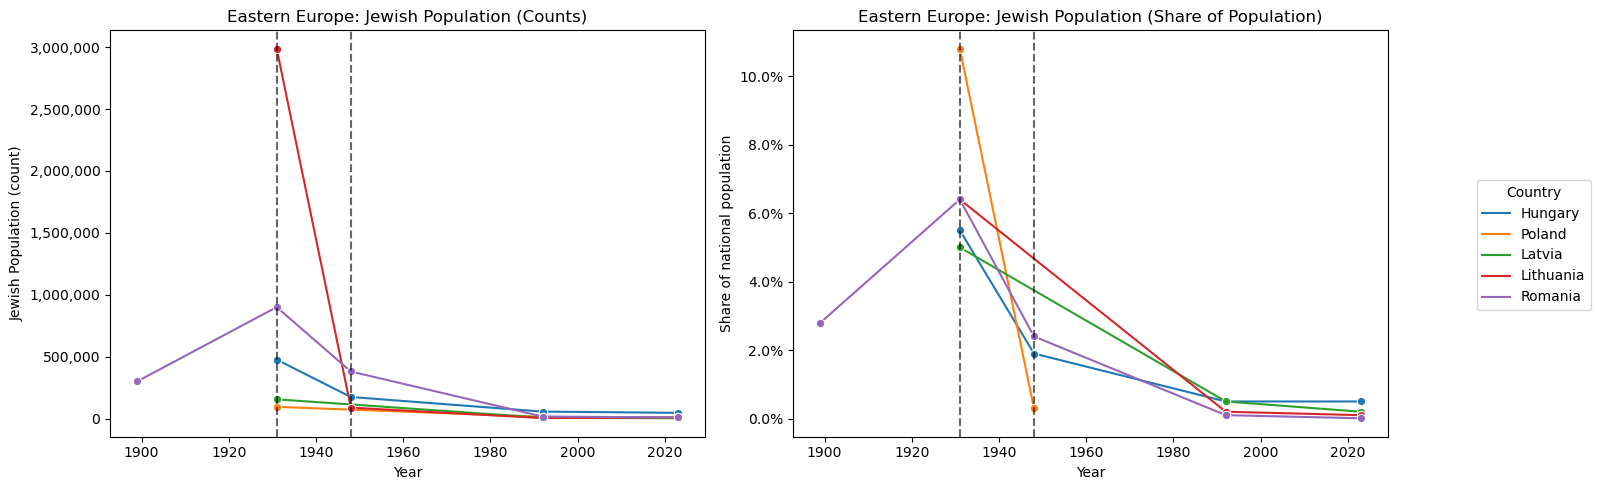

In [213]:
countries = ['Poland', 'Hungary', 'Latvia', 'Lithuania','Romania']

plot_counts_vs_share_for_countries(
    ["Poland", "Hungary", "Latvia", "Lithuania", "Romania"],
    "Eastern Europe: Jewish Population"
)

The Eastern Europe charts reveal a dramatic demographic collapse between 1931 and 1948 across all five countries shown. In absolute terms, Poland experiences the largest decline, followed by Romania and Hungary, reflecting the prewar size of Jewish communities in those countries.

The share-of-population chart reinforces this pattern by showing that Jewish communities did not merely decline in number, but also shrank as a proportion of national populations, indicating that the losses were not offset by population growth among non-Jewish populations.

While the timing and scale of these declines align with the Holocaust and wartime destruction, it is important to note that border changes, postwar emigration, and population transfers also affect national totals in this period.

What can we see when we compare Western European countries?

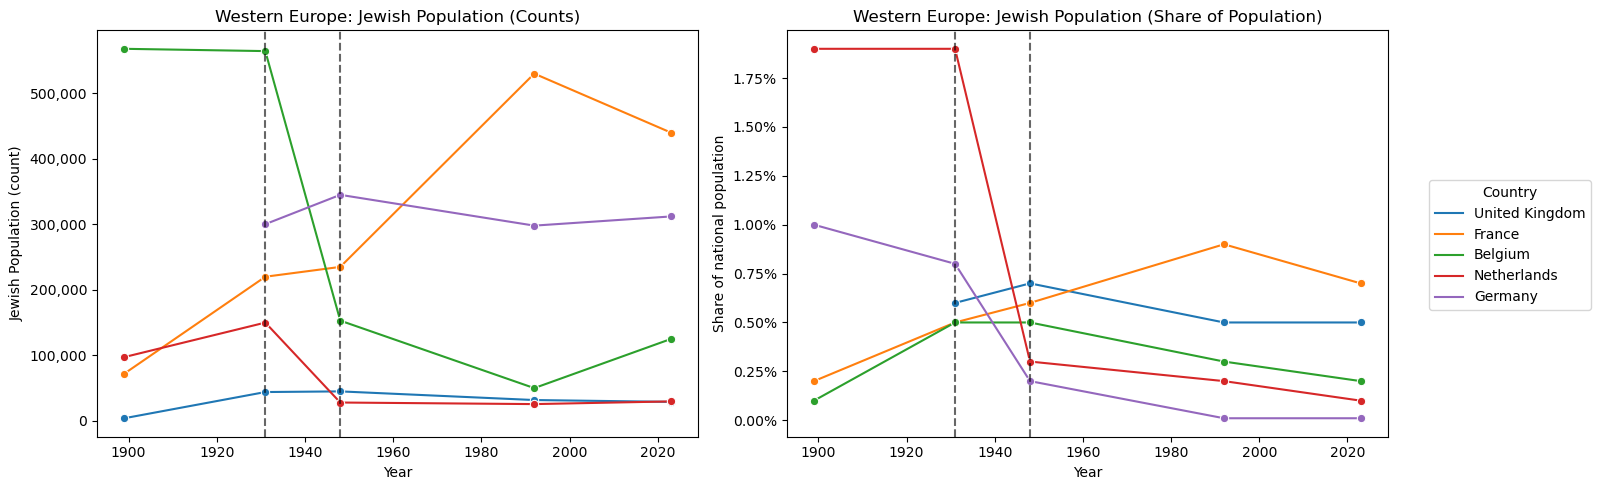

In [214]:
plot_counts_vs_share_for_countries(
    ["France", "Belgium", "Netherlands", "Germany", "United Kingdom"],
    "Western Europe: Jewish Population"
)

Western Europe shows a more uneven pattern than Eastern Europe. In absolute numbers, Jewish populations in several countries continued to grow between 1899 and 1931, reflecting migration from Eastern Europe and relative economic stability.

Between 1931 and 1948, countries such as Germany and the Netherlands experienced apparent declines in population, while others, including France and the United Kingdom, showed smaller declines or relative stability in the dataset.

The share-of-population chart shows that even when absolute numbers recover or stabilize after 1948, Jewish communities often represent a smaller share of the national population than before the war. This suggests postwar recovery did not fully restore prewar demographic presence.

Let's look at another region. What about Latin America?

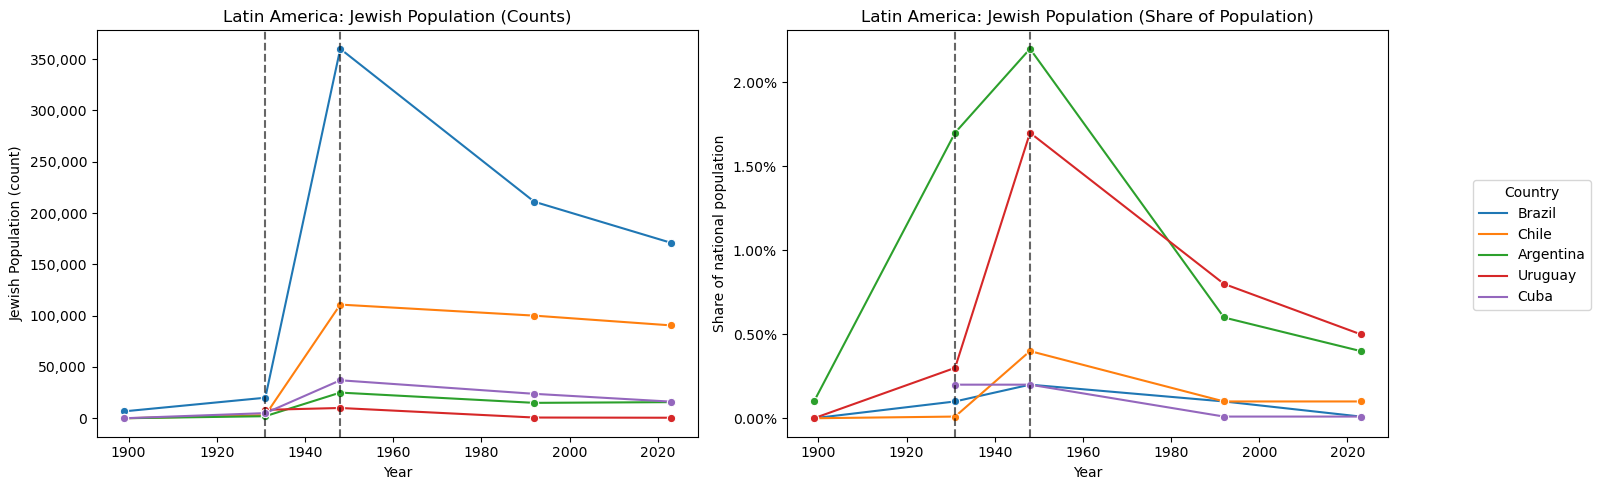

In [215]:
plot_counts_vs_share_for_countries(
    ["Brazil", "Argentina", "Uruguay", "Chile", "Cuba"],
    "Latin America: Jewish Population"
)

The Latin American charts show significant growth in Jewish populations by 1931 and 1948, likely reflecting a combination of prewar migration, wartime displacement, and restrictive immigration policies elsewhere.

In absolute terms, Argentina emerges as the largest Jewish population center in this group by mid-century. However, the share-of-population chart reveals that countries such as Uruguay often have a higher proportional concentration of Jewish residents despite smaller absolute numbers.

After 1948, several countries showed stagnation or decline in both counts and shares, suggesting secondary migration to other regions, including Israel and North America.

Finally, we will compare countries in the Middle East and North Africa (MENA)

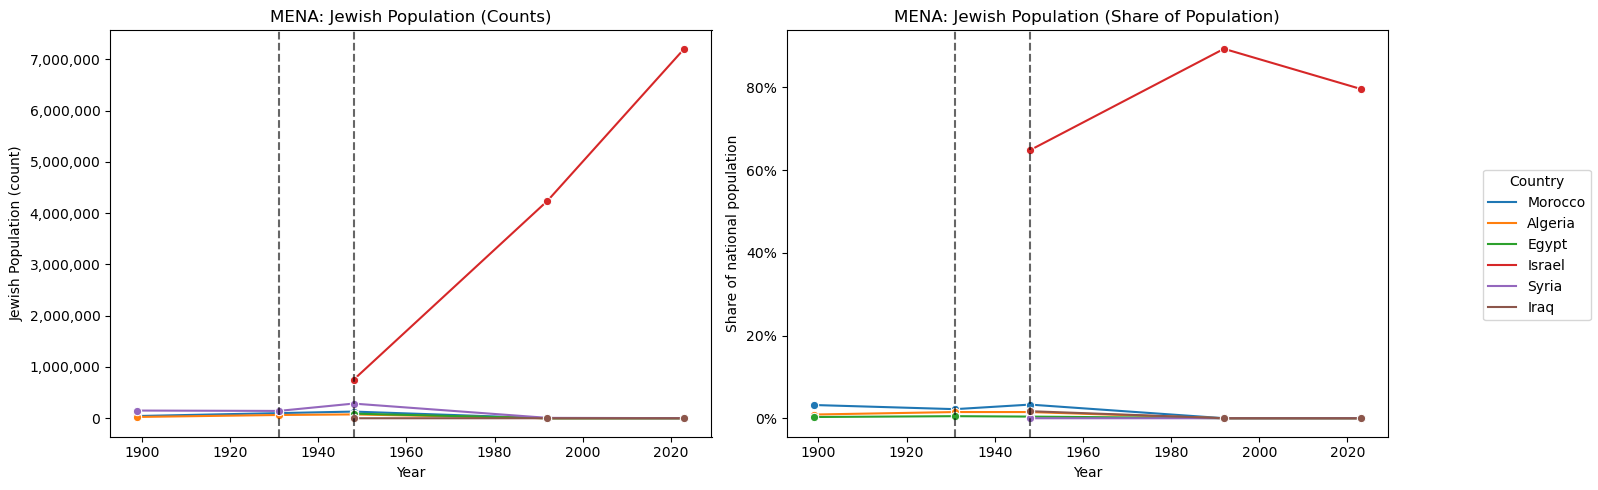

In [218]:
plot_counts_vs_share_for_countries(
    ["Morocco", "Algeria", "Egypt", "Iraq", "Syria", "Israel"],
    "MENA: Jewish Population"
)

This comparison breaks the Middle East & North Africa into individual countries, revealing a clear pattern that is obscured in regional aggregates. In absolute terms, Israel’s Jewish population increases rapidly after 1948, while Jewish populations in Morocco, Algeria, Egypt, Iraq, and Syria decline sharply over the same period.

The count-based chart shows that the post-1948 growth of the Jewish population in MENA is driven almost entirely by Israel, not by growth across the region as a whole. Several North African and Middle Eastern countries that once had substantial Jewish communities saw their populations fall to very low levels by 1992 and 2023.

The share-of-population chart reinforces this interpretation. Israel becomes a Jewish-majority state, while the Jewish share of the population in other MENA countries declines toward zero. This demonstrates that the dramatic rise in MENA’s Jewish population share after 1948 reflects geographic concentration in a single country, rather than widespread Jewish growth throughout the region.

What happens when we look at this region without Israel?

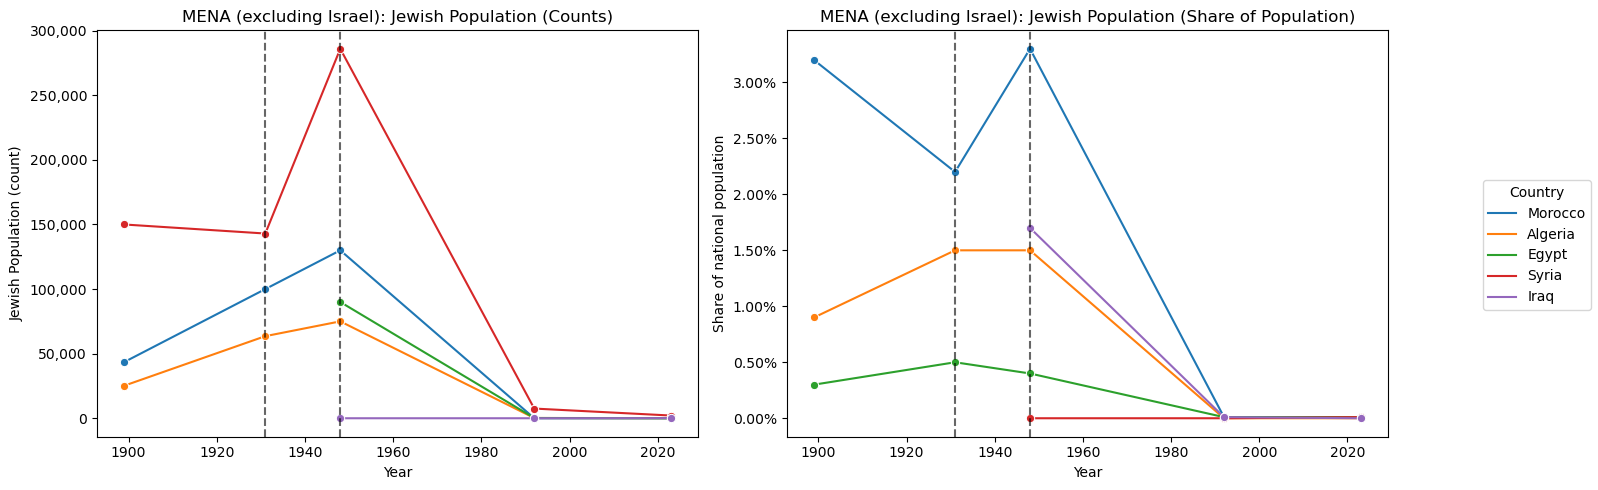

In [219]:
plot_counts_vs_share_for_countries(
    ["Morocco", "Algeria", "Egypt", "Iraq", "Syria"],
    "MENA (excluding Israel): Jewish Population"
)

In absolute terms, Jewish populations in Morocco, Algeria, Egypt, Iraq, and Syria peaked before 1948 and then declined sharply over the following decades.

The count-based chart shows that these declines are not offset by growth in neighboring countries. Instead, Jewish communities across non-Israel MENA countries diminish simultaneously, indicating regional loss rather than internal redistribution. By 1992 and 2023, Jewish populations in these countries were tiny compared to their earlier levels.

The share-of-population chart reinforces this finding. Jewish residents constitute a shrinking and ultimately negligible proportion of national populations across all five countries. Unlike Israel, none of these states has become a new center of Jewish demographic concentration.

## Conclusion
Taken together, these charts demonstrate that Jewish demographic history in the modern era cannot be understood through a single metric. Absolute population counts reveal where people lived in large numbers, while population shares reveal where Jewish communities were most concentrated. The period between 1931 and 1948 represents the most dramatic global rupture in the dataset, while post-1948 patterns reflect migration, state formation, and geopolitical change. Analyzing both dimensions together allows for a more accurate and historically grounded interpretation.

### Further Explorations: Connections to Broader Research Topics
* **National Demographics**: Overlay Jewish population increases and drops with other demographic data from those years, such as national population growth, fertility rates, and death rates.
* **Forced Migration and Refugee Era**: Compare countries with the most significant absolute losses to those with the most essential post-1948 gains using linked bar charts.
* **Minority Comparisons**: Compare Jewish population demographics with those of other minorities, such as Roma/Sinti.
* **Comparative Genocide and Mass Violence**: Compare the magnitude and speed of Jewish population loss (1931–1948) to later cases such as Rwanda.
* **Economic Development and Migration Destinations**: Overlay post-1948 growth with indicators of economic development (GDP per capita, HDI).

These further explorations show that Jewish demographic history is not an isolated case, but a lens through which broader processes—war, migration, state formation, minority survival, and historical memory—can be studied quantitatively and comparatively.